In [133]:
import web3
print(web3.__version__)

7.6.0


In [134]:
from web3 import Web3

# Required to work with most tesnets
from web3.middleware import ExtraDataToPOAMiddleware

In [135]:
## Instanciate web3 object!

# Get the RPC http endpoint from alchemy
provider_url = "https://rpc-amoy.polygon.technology"

w3 = Web3(Web3.HTTPProvider(provider_url))

# Need to add a middleware to adjust the response, only used in testnets
# https://web3py.readthedocs.io/en/stable/middleware.html
w3.middleware_onion.inject(ExtraDataToPOAMiddleware, layer=0)

# Methods

## Get current block

### RPC Call

In [136]:
import json
import requests

# Construct the RPC request
rpc_request = {
    "jsonrpc": "2.0",
    "method": "eth_getBlockByNumber",
    "params": ["latest", True], # for all transactions in block 
    "id": 1 
}

# Send the RPC request
response = requests.post(provider_url, data=json.dumps(rpc_request), headers={'Content-Type': 'application/json'})

# Parse the response
if response.status_code == 200:
    data = response.json()
    block_data = data["result"]
    block_number = int(block_data["number"],16)
    print("Block Number:", block_number)
else:
    print("RPC request failed.")

Block Number: 14898162


### Web3

In [137]:
print(f'Block Number: {w3.eth.get_block("latest")["number"]}')

Block Number: 14898162


##  Get balance

In [138]:
wallet_address = "0xc39f29A8766974577658DBF2D687d004Ed4E9c14"
wallet_pk = "d111b1ff547b958f24f71629c84d7700f834299bfee7202a60b8b2569a15fa49"

### RPC Call

In [139]:
import json
import requests

# Construct the RPC request
rpc_request = {
    "jsonrpc": "2.0",
    "method": "eth_getBalance",
    "params": [wallet_address, "latest"], 
    "id": 1  
}

# Send the RPC request
response = requests.post(provider_url, data=json.dumps(rpc_request), headers={'Content-Type': 'application/json'})

# Parse the response
if response.status_code == 200:
    data = response.json()
    balance_wei = int(data["result"], 16)  # Convert the balance from hexadecimal to an integer
    balance_ether = balance_wei / 10**18  # Convert from Wei to Ether
    print(f"Balance of {wallet_address}: {balance_ether} ETH")
else:
    print("RPC request failed.")

Balance of 0xc39f29A8766974577658DBF2D687d004Ed4E9c14: 0.198325594609946 ETH


### Web3

In [140]:
# Using Web3
balance = w3.eth.get_balance(wallet_address)
print(f"Balance of {wallet_address} in wei: {balance}")

scaled_balance = w3.from_wei(balance, "ether")
print(f"Balance of {wallet_address} in eth: {scaled_balance}")


Balance of 0xc39f29A8766974577658DBF2D687d004Ed4E9c14 in wei: 198325594609946000
Balance of 0xc39f29A8766974577658DBF2D687d004Ed4E9c14 in eth: 0.198325594609946


## Send eth

In [141]:
# Helper function
def get_balance(address):
    balance = w3.eth.get_balance(address)
    scaled_balance = w3.from_wei(balance, "ether")
    return scaled_balance

### Web3

In [142]:
# To generate the gas price
from web3.gas_strategies.time_based import fast_gas_price_strategy

recipient_address = "0x0c5EA4F0f024457343c5A9A99a34BE358Daac843"


# Amount to send in Wei (0.001 ETH in Wei)
amount_wei = w3.to_wei(0.000012345, 'ether')

# Nonce (can be obtained using web3.eth.getTransactionCount)
nonce = w3.eth.get_transaction_count(wallet_address)

# set fast gas price strategy
w3.eth.set_gas_price_strategy(fast_gas_price_strategy)

# Create a transaction dictionary
transaction = {
    'to': recipient_address,
    'value': amount_wei,
    'gas': 25000,  # Gas limit for a standard transaction
    "gasPrice": w3.eth.generate_gas_price(),
    'nonce': nonce,
    'chainId': w3.eth.chain_id,  # 1 for the Ethereum Mainnet (adjust for other networks)
}


# Sign the transaction
from web3 import Account
signed_transaction = Account.sign_transaction(transaction, wallet_pk)

In [143]:

# Check balance after
print(f"Balance of {wallet_address}: {get_balance(wallet_address)}")
print(f"Balance of {recipient_address}: {get_balance(recipient_address)}")

transaction_hash = w3.eth.send_raw_transaction(signed_transaction[0])
print(f"Transaction hash: {transaction_hash.hex()}")

# Check balance after
print(f"Balance of {wallet_address}: {get_balance(recipient_address)}")
print(f"Balance of {recipient_address}: {get_balance(recipient_address)}")

Balance of 0xc39f29A8766974577658DBF2D687d004Ed4E9c14: 0.198325594609946
Balance of 0x0c5EA4F0f024457343c5A9A99a34BE358Daac843: 0.000037035
Transaction hash: a3ac81aee46ca6bd6c13a6e2f0de3d5c40530af841e641f3678c92e9b4a7c751
Balance of 0xc39f29A8766974577658DBF2D687d004Ed4E9c14: 0.000037035
Balance of 0x0c5EA4F0f024457343c5A9A99a34BE358Daac843: 0.000037035


In [144]:
from web3.exceptions import TransactionNotFound
import time

#Wait for the transaction to be mined
while True:
    print("Waiting for transaction...")
    try:
        transaction_receipt = w3.eth.get_transaction_receipt(transaction_hash)
        if transaction_receipt is not None:
            if transaction_receipt['status'] == 1:
                print(transaction_receipt)
            else:
                print("Transaction failed.")
            break
        # Wait for a few seconds before checking again
    except TransactionNotFound:
        print("Not Found!")
        time.sleep(0.25)

Waiting for transaction...
Not Found!
Waiting for transaction...
Not Found!
Waiting for transaction...
Not Found!
Waiting for transaction...
Not Found!
Waiting for transaction...
AttributeDict({'blockHash': HexBytes('0x66c9b577b1efc20d10b0a072bf2083ec8e961949a6ed96d9b5113a3626654f48'), 'blockNumber': 14898184, 'contractAddress': None, 'cumulativeGasUsed': 157106, 'effectiveGasPrice': 28633799646, 'from': '0xc39f29A8766974577658DBF2D687d004Ed4E9c14', 'gasUsed': 21000, 'logs': [AttributeDict({'address': '0x0000000000000000000000000000000000001010', 'topics': [HexBytes('0xe6497e3ee548a3372136af2fcb0696db31fc6cf20260707645068bd3fe97f3c4'), HexBytes('0x0000000000000000000000000000000000000000000000000000000000001010'), HexBytes('0x000000000000000000000000c39f29a8766974577658dbf2d687d004ed4e9c14'), HexBytes('0x0000000000000000000000000c5ea4f0f024457343c5a9a99a34be358daac843')], 'data': HexBytes('0x00000000000000000000000000000000000000000000000000000b3a4b56fa000000000000000000000000000000000

In [145]:
# Check balance after
print(f"Balance of {wallet_address}: {get_balance(wallet_address)}")
print(f"Balance of {recipient_address}: {get_balance(recipient_address)}")

Balance of 0xc39f29A8766974577658DBF2D687d004Ed4E9c14: 0.19771193981738
Balance of 0x0c5EA4F0f024457343c5A9A99a34BE358Daac843: 0.00004938


# Filtering

In [146]:
from web3 import Web3
import time

# https://polygonscan.com/tx/0x9e6fa055687465ff9a47593381298b2c280b846f92fc2153a85b2e2439eaef04
# Get the RPC http endpoint from alchemy
# provider_url = "https://polygon.llamarpc.com" public and free!
provider_url = "https://polygon-mainnet.g.alchemy.com/v2/CIbzNnYgUgzchulujOTtzhVAdIdIG_n4"

w3 = Web3(Web3.HTTPProvider(provider_url))
# Need to add a middleware to adjust the response, only used in testnets
w3.middleware_onion.inject(ExtraDataToPOAMiddleware, layer=0)

event_signature_hash = Web3.keccak(text="Swap(address,uint256,uint256,uint256,uint256,address)").hex()

block = w3.eth.get_block(64720237)
for tx_hash in block.transactions:
    hex_transactions_hash = tx_hash.hex().lower()
    print(hex_transactions_hash)
    
    # Now we get the receipt
    # 0x9e6fa055687465ff9a47593381298b2c280b846f92fc2153a85b2e2439eaef04
    if hex_transactions_hash == "9e6fa055687465ff9a47593381298b2c280b846f92fc2153a85b2e2439eaef04".lower():
        print("Transaction found!")
        receipt = w3.eth.get_transaction_receipt(hex_transactions_hash)
        for log in receipt.logs:
            log_signature = log["topics"][0].hex()
            if event_signature_hash == log_signature:
                print("Swap!") # this is the Event hash! We can decode the parameters now!
                break
            else:
                print("No swap")
        
    time.sleep(0.25)



aca079f8a837c61019a5d4977a8363fc6e7b035b8ff1899fac3317faf5f62c4c
9e6fa055687465ff9a47593381298b2c280b846f92fc2153a85b2e2439eaef04
Transaction found!
No swap
No swap
No swap
No swap
Swap!
d5d58f449828cfebdc8d51127c1d25e6d2c2f0802f7ecbfe176d534910154be0
ff3f6b309b3c4a8b0abf1c296b437b10802498027e4ba46029cad8ad87da85e5
ed04669722cb94fbcf267e9a4cf913e2c327ac1786a2ffa545ac41989b90538f
f53d05db1e4af97892a6ef575a3cb7735e4f778e4f6e8a5029e80cdcf72d61e9
3d2f56db9dab40a20e7839f25b29c31fd8ed753d997bf3d9624de2d544af2e5b
bb3fa2e4cb8ba5745f232e934d5ddc4815ea5af6981cc2379e86a4cc865b4cc5
f34612aa67439e27282b29164fe03ce43167d18cb1b0e4dfe8734a563db44440
642816aa2a067ad6ac2456e131494044747911bff2ec3b3d65d44a14876e1480
7e34b0b633e87ad358741754d437352880dd44e3bda56877a2d78c3d24b49c49
655b9b6b4271e32dc7e19a033ab237c01227e8faf4cacacada4dee9dc5743fca
be7f01266625984f1ce464385217b4663942d7134ec4510cd9cb74456f871e3f
415e8c5c7b6aeed12320ab78523f09569ca5daa9c02ddd9d4d451764d894bc75
8d421ffd3439738821b7b056e06bc2588

### Tarea propuesta #1

Crear un programa fuera del entorno interactivo de python que permita suscribirse por websockets en tiempo real a eventos!

# Contratos

In [147]:
# https://polygonscan.com/address/0xc35dadb65012ec5796536bd9864ed8773abc74c4#readContract factory
# https://polygonscan.com/address/0x1b02da8cb0d097eb8d57a175b88c7d8b47997506#code

v2_router_address = "0x1b02da8cb0d097eb8d57a175b88c7d8b47997506"
v2_router_abi = [{"inputs":[{"internalType":"address","name":"_factory","type":"address"},{"internalType":"address","name":"_WETH","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"WETH","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"tokenA","type":"address"},{"internalType":"address","name":"tokenB","type":"address"},{"internalType":"uint256","name":"amountADesired","type":"uint256"},{"internalType":"uint256","name":"amountBDesired","type":"uint256"},{"internalType":"uint256","name":"amountAMin","type":"uint256"},{"internalType":"uint256","name":"amountBMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"addLiquidity","outputs":[{"internalType":"uint256","name":"amountA","type":"uint256"},{"internalType":"uint256","name":"amountB","type":"uint256"},{"internalType":"uint256","name":"liquidity","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"amountTokenDesired","type":"uint256"},{"internalType":"uint256","name":"amountTokenMin","type":"uint256"},{"internalType":"uint256","name":"amountETHMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"addLiquidityETH","outputs":[{"internalType":"uint256","name":"amountToken","type":"uint256"},{"internalType":"uint256","name":"amountETH","type":"uint256"},{"internalType":"uint256","name":"liquidity","type":"uint256"}],"stateMutability":"payable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"uint256","name":"reserveIn","type":"uint256"},{"internalType":"uint256","name":"reserveOut","type":"uint256"}],"name":"getAmountIn","outputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"reserveIn","type":"uint256"},{"internalType":"uint256","name":"reserveOut","type":"uint256"}],"name":"getAmountOut","outputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"}],"name":"getAmountsIn","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"}],"name":"getAmountsOut","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountA","type":"uint256"},{"internalType":"uint256","name":"reserveA","type":"uint256"},{"internalType":"uint256","name":"reserveB","type":"uint256"}],"name":"quote","outputs":[{"internalType":"uint256","name":"amountB","type":"uint256"}],"stateMutability":"pure","type":"function"},{"inputs":[{"internalType":"address","name":"tokenA","type":"address"},{"internalType":"address","name":"tokenB","type":"address"},{"internalType":"uint256","name":"liquidity","type":"uint256"},{"internalType":"uint256","name":"amountAMin","type":"uint256"},{"internalType":"uint256","name":"amountBMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"removeLiquidity","outputs":[{"internalType":"uint256","name":"amountA","type":"uint256"},{"internalType":"uint256","name":"amountB","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"liquidity","type":"uint256"},{"internalType":"uint256","name":"amountTokenMin","type":"uint256"},{"internalType":"uint256","name":"amountETHMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"removeLiquidityETH","outputs":[{"internalType":"uint256","name":"amountToken","type":"uint256"},{"internalType":"uint256","name":"amountETH","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"liquidity","type":"uint256"},{"internalType":"uint256","name":"amountTokenMin","type":"uint256"},{"internalType":"uint256","name":"amountETHMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"removeLiquidityETHSupportingFeeOnTransferTokens","outputs":[{"internalType":"uint256","name":"amountETH","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"liquidity","type":"uint256"},{"internalType":"uint256","name":"amountTokenMin","type":"uint256"},{"internalType":"uint256","name":"amountETHMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"bool","name":"approveMax","type":"bool"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"removeLiquidityETHWithPermit","outputs":[{"internalType":"uint256","name":"amountToken","type":"uint256"},{"internalType":"uint256","name":"amountETH","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"token","type":"address"},{"internalType":"uint256","name":"liquidity","type":"uint256"},{"internalType":"uint256","name":"amountTokenMin","type":"uint256"},{"internalType":"uint256","name":"amountETHMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"bool","name":"approveMax","type":"bool"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"removeLiquidityETHWithPermitSupportingFeeOnTransferTokens","outputs":[{"internalType":"uint256","name":"amountETH","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"tokenA","type":"address"},{"internalType":"address","name":"tokenB","type":"address"},{"internalType":"uint256","name":"liquidity","type":"uint256"},{"internalType":"uint256","name":"amountAMin","type":"uint256"},{"internalType":"uint256","name":"amountBMin","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"bool","name":"approveMax","type":"bool"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"removeLiquidityWithPermit","outputs":[{"internalType":"uint256","name":"amountA","type":"uint256"},{"internalType":"uint256","name":"amountB","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapETHForExactTokens","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapExactETHForTokens","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapExactETHForTokensSupportingFeeOnTransferTokens","outputs":[],"stateMutability":"payable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapExactTokensForETH","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapExactTokensForETHSupportingFeeOnTransferTokens","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapExactTokensForTokens","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountIn","type":"uint256"},{"internalType":"uint256","name":"amountOutMin","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapExactTokensForTokensSupportingFeeOnTransferTokens","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"uint256","name":"amountInMax","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapTokensForExactETH","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amountOut","type":"uint256"},{"internalType":"uint256","name":"amountInMax","type":"uint256"},{"internalType":"address[]","name":"path","type":"address[]"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"deadline","type":"uint256"}],"name":"swapTokensForExactTokens","outputs":[{"internalType":"uint256[]","name":"amounts","type":"uint256[]"}],"stateMutability":"nonpayable","type":"function"},{"stateMutability":"payable","type":"receive"}]

v2_router_contract = w3.eth.contract(address=Web3.to_checksum_address(v2_router_address),abi=v2_router_abi)

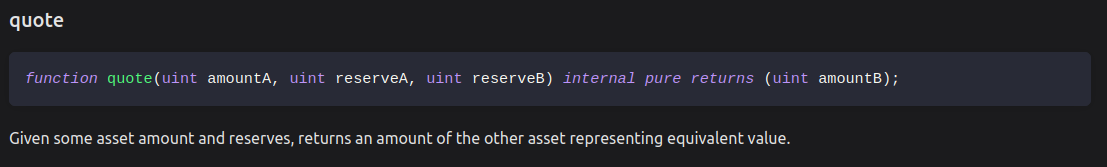

In [149]:
sushi_address = "0x3c9F4EEa18B02ee331218646Fea59EE3661d2A61" # this has 18 decimals
usdc_address = "0x52D800ca262522580CeBAD275395ca6e7598C014" # this has 6 decimals

amount_in = w3.to_wei("1.234", "ether")
reserve_a = w3.to_wei("300", "ether")
reserve_b = w3.to_wei("20", "ether")

amount_out = v2_router_contract.functions.quote(amount_in, reserve_a, reserve_b).call()
print(w3.from_wei(amount_out, "ether"))

0.082266666666666666


In [150]:
# Get the RPC http endpoint from alchemy
# provider_url = "https://polygon.llamarpc.com" public and free!
provider_url = "https://eth-mainnet.g.alchemy.com/v2/CIbzNnYgUgzchulujOTtzhVAdIdIG_n4"

w3 = Web3(Web3.HTTPProvider(provider_url))

WETH_ADDRESS = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
WETH_ABI = '[{"constant":true,"inputs":[],"name":"name","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"guy","type":"address"},{"name":"wad","type":"uint256"}],"name":"approve","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"totalSupply","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"src","type":"address"},{"name":"dst","type":"address"},{"name":"wad","type":"uint256"}],"name":"transferFrom","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"wad","type":"uint256"}],"name":"withdraw","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"decimals","outputs":[{"name":"","type":"uint8"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"}],"name":"balanceOf","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"symbol","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"dst","type":"address"},{"name":"wad","type":"uint256"}],"name":"transfer","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[],"name":"deposit","outputs":[],"payable":true,"stateMutability":"payable","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"},{"name":"","type":"address"}],"name":"allowance","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"payable":true,"stateMutability":"payable","type":"fallback"},{"anonymous":false,"inputs":[{"indexed":true,"name":"src","type":"address"},{"indexed":true,"name":"guy","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"src","type":"address"},{"indexed":true,"name":"dst","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"dst","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Deposit","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"src","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Withdrawal","type":"event"}]'

weth_contract = w3.eth.contract(address=WETH_ADDRESS, abi=WETH_ABI)

# fetch transfer events in the last block
logs = weth_contract.events.Transfer().get_logs(from_block=w3.eth.block_number)

for log in logs:
   print(f"Transfer of {w3.from_wei(log.args.wad, 'ether')} WETH from {log.args.src} to {log.args.dst}")


Transfer of 5.560316648978144248 WETH from 0xc3Db44ADC1fCdFd5671f555236eae49f4A8EEa18 to 0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf
Transfer of 40.758919666767231965 WETH from 0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640 to 0x6F1cDbBb4d53d226CF4B917bF768B94acbAB6168
Transfer of 0.263431188103602901 WETH from 0xB048E079F669dc5110E2662d18B3ffc69fd8a803 to 0x3A10dC1A145dA500d5Fba38b9EC49C8ff11a981F
Transfer of 9.897427594771007743 WETH from 0xc7bBeC68d12a0d1830360F8Ec58fA599bA1b0e9b to 0x6F1cDbBb4d53d226CF4B917bF768B94acbAB6168
Transfer of 0.2997 WETH from 0x7D0CcAa3Fac1e5A943c5168b6CEd828691b46B36 to 0xE0554a476A092703abdB3Ef35c80e0D76d32939F
Transfer of 9.213002651132744582 WETH from 0xE0554a476A092703abdB3Ef35c80e0D76d32939F to 0x6F1cDbBb4d53d226CF4B917bF768B94acbAB6168
Transfer of 0.007908547061858374 WETH from 0x3328F7f4A1D1C57c35df56bBf0c9dCAFCA309C49 to 0x82AC7c7F798253225E345e4F59D103176eE46983
Transfer of 0.007968319498489569 WETH from 0x3328F7f4A1D1C57c35df56bBf0c9dCAFCA309C49 to 